In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import joblib
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
data = pd.read_csv('XRPUSDT20182024new.csv')
print(" Shape of the XRPUSDT 2023-2024 is: ", data.shape,"\n",
     "The number", data.shape[0], "shows number of samples and the",
     data.shape[1], "shows number of columns.")
data.head(10).style.set_properties(**{'background-color': '#b5caff',
                           'color': 'black',
                           'border-color': 'black'})

 Shape of the XRPUSDT 2023-2024 is:  (2192, 7) 
 The number 2192 shows number of samples and the 7 shows number of columns.


,Date,Price,Open,High,Low,Vol,Change %
0,5/26/2024,0.534100,0.541600,0.541800,0.532800,178450000.000000,-1.39%
1,5/25/2024,0.541600,0.535900,0.542500,0.533400,246380000.000000,1.09%
2,5/24/2024,0.535800,0.528800,0.537200,0.516900,513880000.000000,1.33%
3,5/23/2024,0.528800,0.526900,0.545600,0.509100,948100000.000000,0.38%
4,5/22/2024,0.526800,0.537200,0.538200,0.523600,509460000.000000,-1.94%
5,5/21/2024,0.537200,0.537700,0.556500,0.532100,812410000.000000,-0.09%
6,5/20/2024,0.537700,0.509600,0.537900,0.506700,672450000.000000,5.49%
7,5/19/2024,0.509700,0.521300,0.523400,0.507100,209990000.000000,-2.22%
8,5/18/2024,0.521200,0.523400,0.525600,0.518800,171860000.000000,-0.41%
9,5/17/2024,0.523400,0.515600,0.528700,0.513700,456520000.000000,1.52%


In [4]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2192 non-null   object 
 1   Price     2192 non-null   float64
 2   Open      2192 non-null   float64
 3   High      2192 non-null   float64
 4   Low       2192 non-null   float64
 5   Vol       2192 non-null   float64
 6   Change %  2192 non-null   object 
dtypes: float64(5), object(2)
memory usage: 120.0+ KB


In [5]:
df.drop(['Change %'], axis=1, inplace=True)

In [6]:
df = df.iloc[::-1]
df.reset_index(inplace=True)

In [7]:
df.isnull().sum()

,0
index,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol,0


In [8]:
df.rename(columns = {'Vol':'Volume'}, inplace = True)
df.rename(columns = {'Price':'Close'}, inplace = True)

In [9]:
print(df.duplicated().sum())

0


In [10]:
df.drop(['index'], axis=1, inplace=True)

In [11]:
df.head(10).style.set_properties(**{'background-color': '#b5caff',
                           'color': 'black',
                           'border-color': 'black'})

,Date,Close,Open,High,Low,Volume
0,5/26/2018,0.608800,0.605600,0.624700,0.598900,99110000.000000
1,5/27/2018,0.604600,0.608800,0.611900,0.598800,95150000.000000
2,5/28/2018,0.547600,0.604700,0.607500,0.546000,158340000.000000
3,5/29/2018,0.599400,0.547600,0.608800,0.544400,155950000.000000
4,5/30/2018,0.593800,0.599400,0.625500,0.578600,132830000.000000
5,5/31/2018,0.611000,0.594100,0.621000,0.586600,123380000.000000
6,6/1/2018,0.621100,0.611000,0.623600,0.601900,132400000.000000
7,6/2/2018,0.642900,0.621100,0.650600,0.615500,145530000.000000
8,6/3/2018,0.688000,0.642900,0.688000,0.639300,127980000.000000
9,6/4/2018,0.656000,0.688000,0.704300,0.635800,194540000.000000


In [12]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [13]:
df['Volume'] = df['Volume'].astype('float64')

In [14]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
               vertical_spacing=0.03, subplot_titles=('Ripple', 'Volume'),
               row_width=[0.2, 0.7])

fig.add_trace(go.Candlestick(x=df["Date"], open=df["Open"], high=df["High"],
                low=df["Low"], close=df["Close"], name="Ripple"),
                row=1, col=1
)

fig.update_layout(
    yaxis_title='XRPUSDT',
    shapes = [dict(
        x0='2018-05-22', x1='2024-05-22', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
)

fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], showlegend=False), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

In [15]:
df["5d_sma"] = df["Close"].rolling(5).mean()
df["9d_sma"] = df["Close"].rolling(9).mean()
df["17d_sma"] = df["Close"].rolling(17).mean()

In [16]:
df.head(17).style.set_properties(**{'background-color': '#b5caff',
                           'color': 'black',
                           'border-color': 'black'})

,Date,Close,Open,High,Low,Volume,5d_sma,9d_sma,17d_sma
0,2018-05-26 00:00:00,0.608800,0.605600,0.624700,0.598900,99110000.000000,nan,nan,nan
1,2018-05-27 00:00:00,0.604600,0.608800,0.611900,0.598800,95150000.000000,nan,nan,nan
2,2018-05-28 00:00:00,0.547600,0.604700,0.607500,0.546000,158340000.000000,nan,nan,nan
3,2018-05-29 00:00:00,0.599400,0.547600,0.608800,0.544400,155950000.000000,nan,nan,nan
4,2018-05-30 00:00:00,0.593800,0.599400,0.625500,0.578600,132830000.000000,0.590840,nan,nan
5,2018-05-31 00:00:00,0.611000,0.594100,0.621000,0.586600,123380000.000000,0.591280,nan,nan
6,2018-06-01 00:00:00,0.621100,0.611000,0.623600,0.601900,132400000.000000,0.594580,nan,nan
7,2018-06-02 00:00:00,0.642900,0.621100,0.650600,0.615500,145530000.000000,0.613640,nan,nan
8,2018-06-03 00:00:00,0.688000,0.642900,0.688000,0.639300,127980000.000000,0.631360,0.613022,nan
9,2018-06-04 00:00:00,0.656000,0.688000,0.704300,0.635800,194540000.000000,0.643800,0.618267,nan


In [17]:
df['5d_sma'] = df['5d_sma'].fillna(df['Close'])
df['9d_sma'] = df['9d_sma'].fillna(df['Close'])
df['17d_sma'] = df['17d_sma'].fillna(df['Close'])

In [18]:
df.head(17).style.set_properties(**{'background-color': '#b5caff',
                           'color': 'black',
                           'border-color': 'black'})

,Date,Close,Open,High,Low,Volume,5d_sma,9d_sma,17d_sma
0,2018-05-26 00:00:00,0.608800,0.605600,0.624700,0.598900,99110000.000000,0.608800,0.608800,0.608800
1,2018-05-27 00:00:00,0.604600,0.608800,0.611900,0.598800,95150000.000000,0.604600,0.604600,0.604600
2,2018-05-28 00:00:00,0.547600,0.604700,0.607500,0.546000,158340000.000000,0.547600,0.547600,0.547600
3,2018-05-29 00:00:00,0.599400,0.547600,0.608800,0.544400,155950000.000000,0.599400,0.599400,0.599400
4,2018-05-30 00:00:00,0.593800,0.599400,0.625500,0.578600,132830000.000000,0.590840,0.593800,0.593800
5,2018-05-31 00:00:00,0.611000,0.594100,0.621000,0.586600,123380000.000000,0.591280,0.611000,0.611000
6,2018-06-01 00:00:00,0.621100,0.611000,0.623600,0.601900,132400000.000000,0.594580,0.621100,0.621100
7,2018-06-02 00:00:00,0.642900,0.621100,0.650600,0.615500,145530000.000000,0.613640,0.642900,0.642900
8,2018-06-03 00:00:00,0.688000,0.642900,0.688000,0.639300,127980000.000000,0.631360,0.613022,0.688000
9,2018-06-04 00:00:00,0.656000,0.688000,0.704300,0.635800,194540000.000000,0.643800,0.618267,0.656000


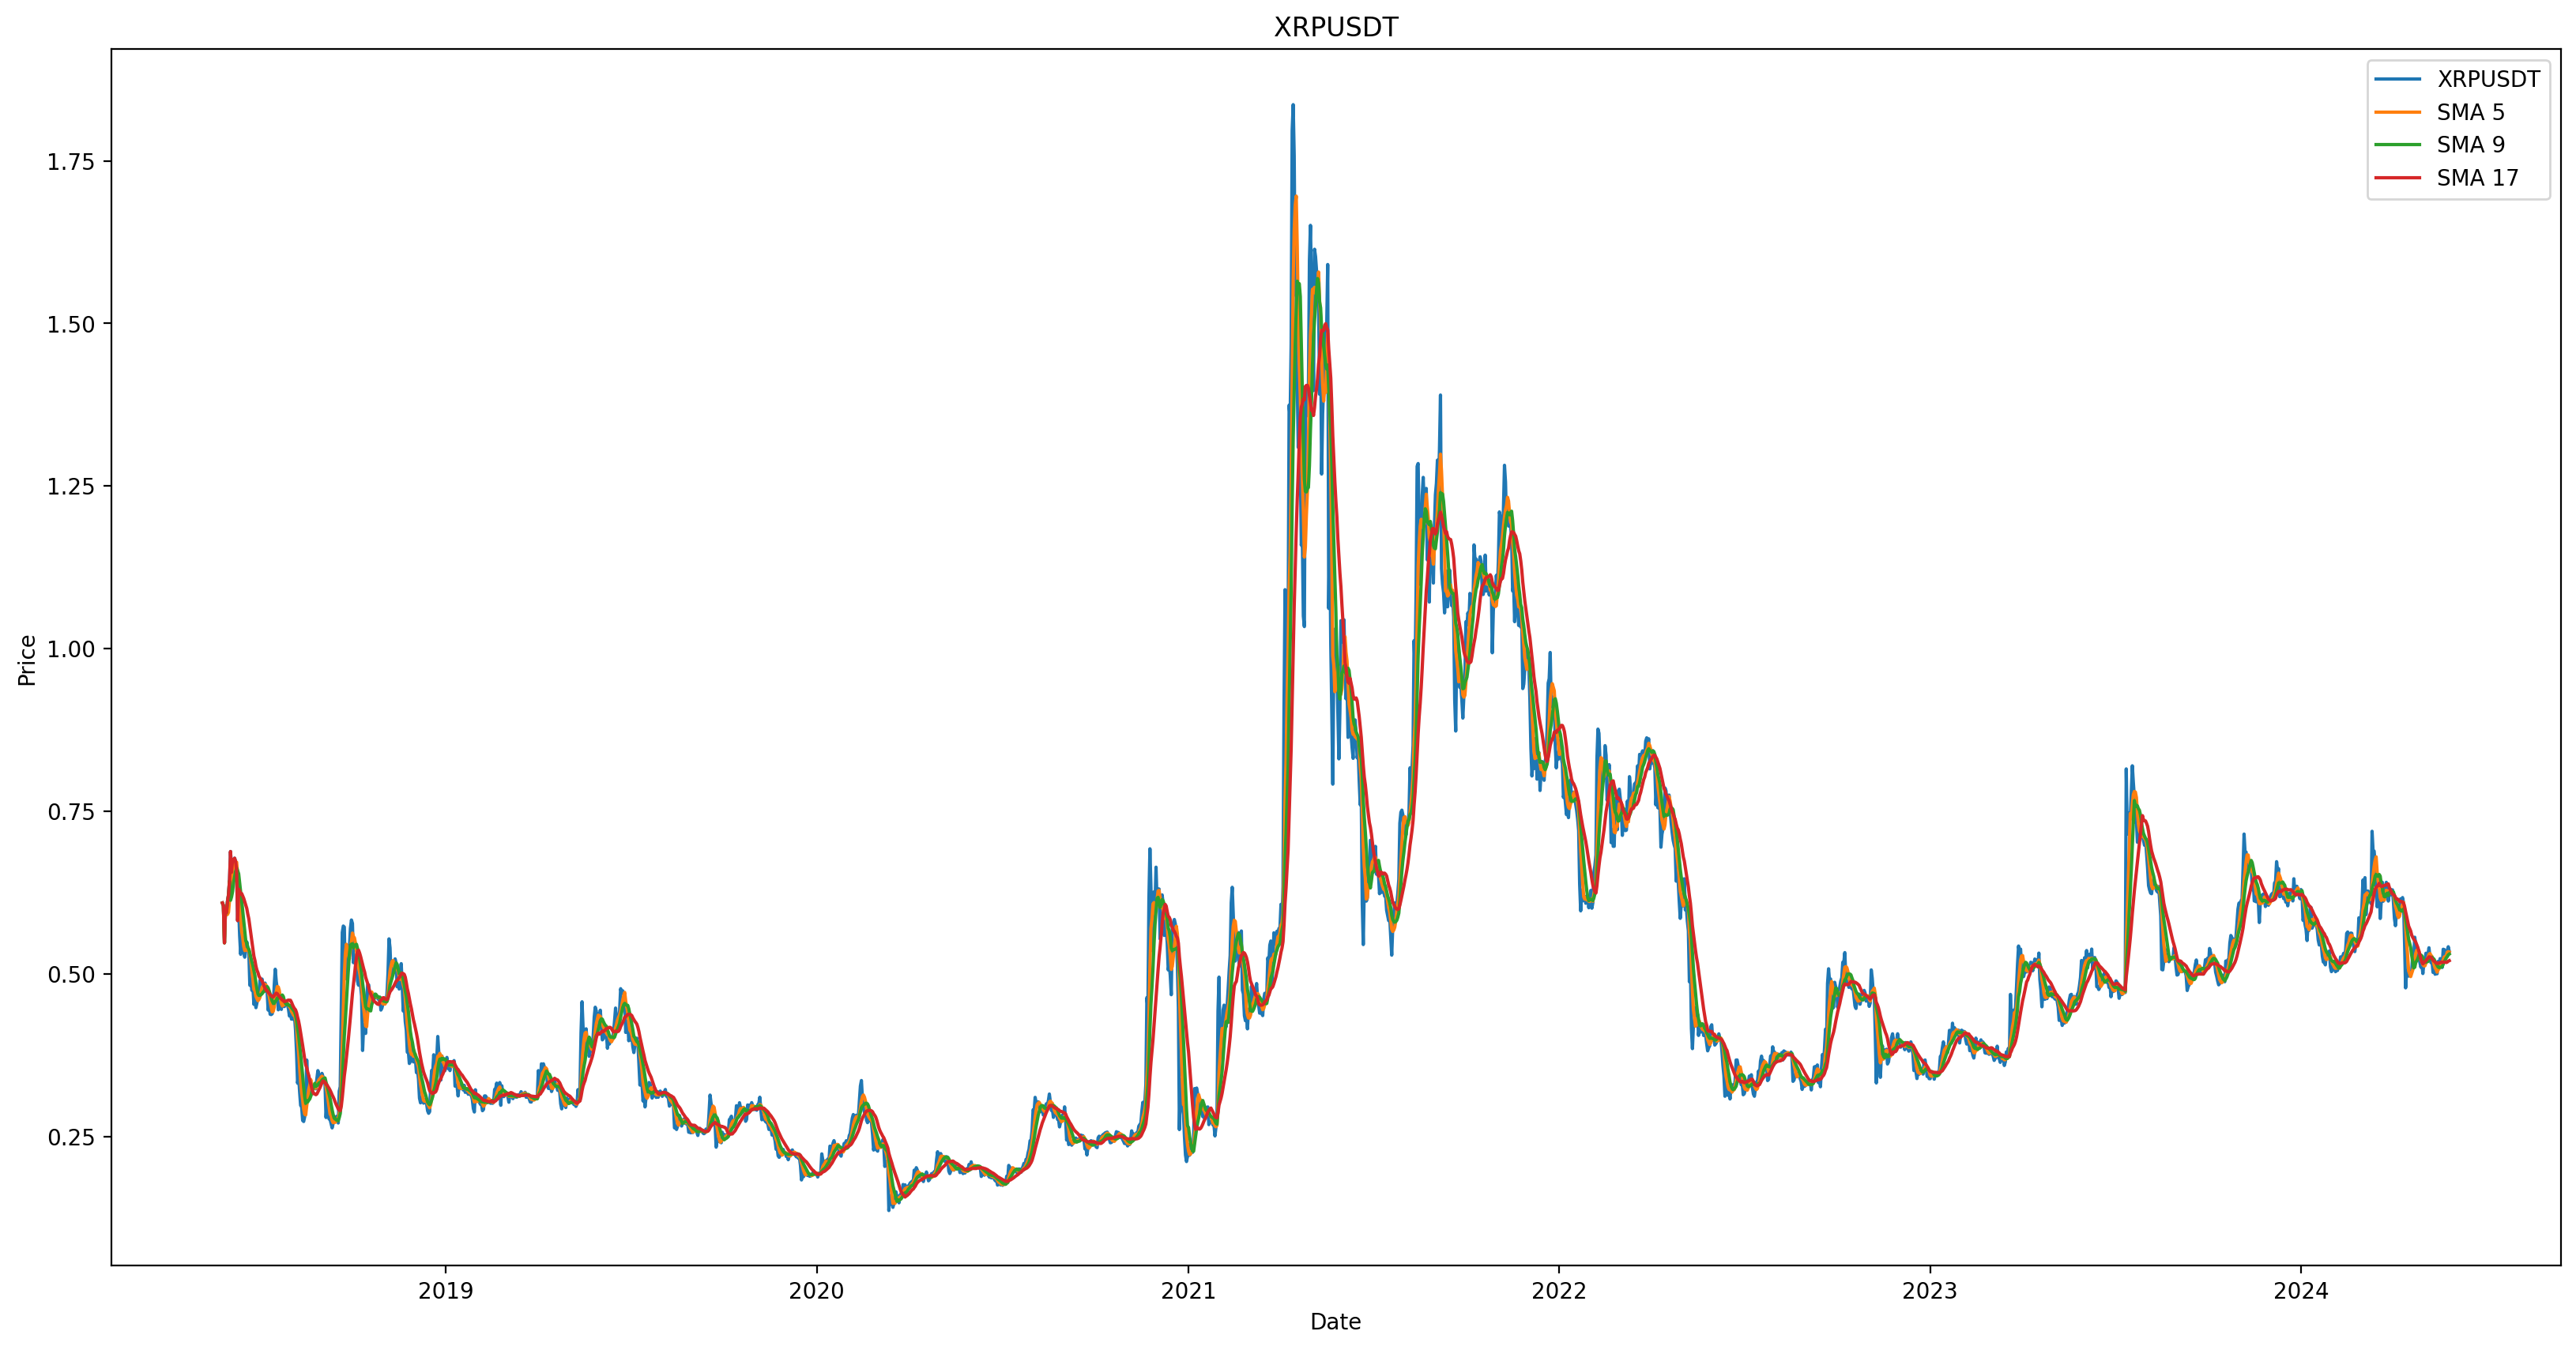

In [19]:
plt.figure(figsize=(20,10), dpi=200)
plt.plot(df['Date'], df['Close'], label='XRPUSDT')
plt.plot(df['Date'], df['5d_sma'], label='SMA 5')
plt.plot(df['Date'], df['9d_sma'], label='SMA 9')
plt.plot(df['Date'], df['17d_sma'], label='SMA 17')
plt.title('XRPUSDT')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.show()

In [20]:
fig = go.Figure(data=go.Candlestick(x=df["Date"], open=df["Open"], high=df["High"],
                low=df["Low"], close=df["Close"], name="XRP"))
fig.update_layout(xaxis_rangeslider_visible=False)

fig.add_trace(go.Scatter(x=df['Date'],y=df['5d_sma'], line_color='#7295ee', name="SMA5",mode='lines'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['9d_sma'], line_color='#fcb539', name="SMA9",mode='lines'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['17d_sma'], line_color='#bd39fc', name="SMA17",mode='lines'))

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
)

fig.show()

In [21]:
# Define parameters
window_size = 15
num_std = 4

# Calculate rolling mean and standard deviation 5d
rolling_mean_5 = np.convolve(df['5d_sma'], np.ones(window_size)/window_size, mode='valid')
rolling_std_5 = np.std([df['5d_sma'][i:i+window_size] for i in range(len(df['5d_sma'])-window_size+1)], axis=1)

# Calculate Bollinger Bands 5d
upper_band_5 = rolling_mean_5 + num_std * rolling_std_5
lower_band_5 = rolling_mean_5 - num_std * rolling_std_5

# Calculate rolling mean and standard deviation 9d
rolling_mean_9 = np.convolve(df['9d_sma'], np.ones(window_size)/window_size, mode='valid')
rolling_std_9 = np.std([df['9d_sma'][i:i+window_size] for i in range(len(df['9d_sma'])-window_size+1)], axis=1)

# Calculate Bollinger Bands 9d
upper_band_9 = rolling_mean_9 + num_std * rolling_std_9
lower_band_9 = rolling_mean_9 - num_std * rolling_std_9

# Calculate rolling mean and standard deviation 17d
rolling_mean_17 = np.convolve(df['17d_sma'], np.ones(window_size)/window_size, mode='valid')
rolling_std_17 = np.std([df['17d_sma'][i:i+window_size] for i in range(len(df['17d_sma'])-window_size+1)], axis=1)

# Calculate Bollinger Bands 17d
upper_band_17 = rolling_mean_17 + num_std * rolling_std_17
lower_band_17 = rolling_mean_17 - num_std * rolling_std_17


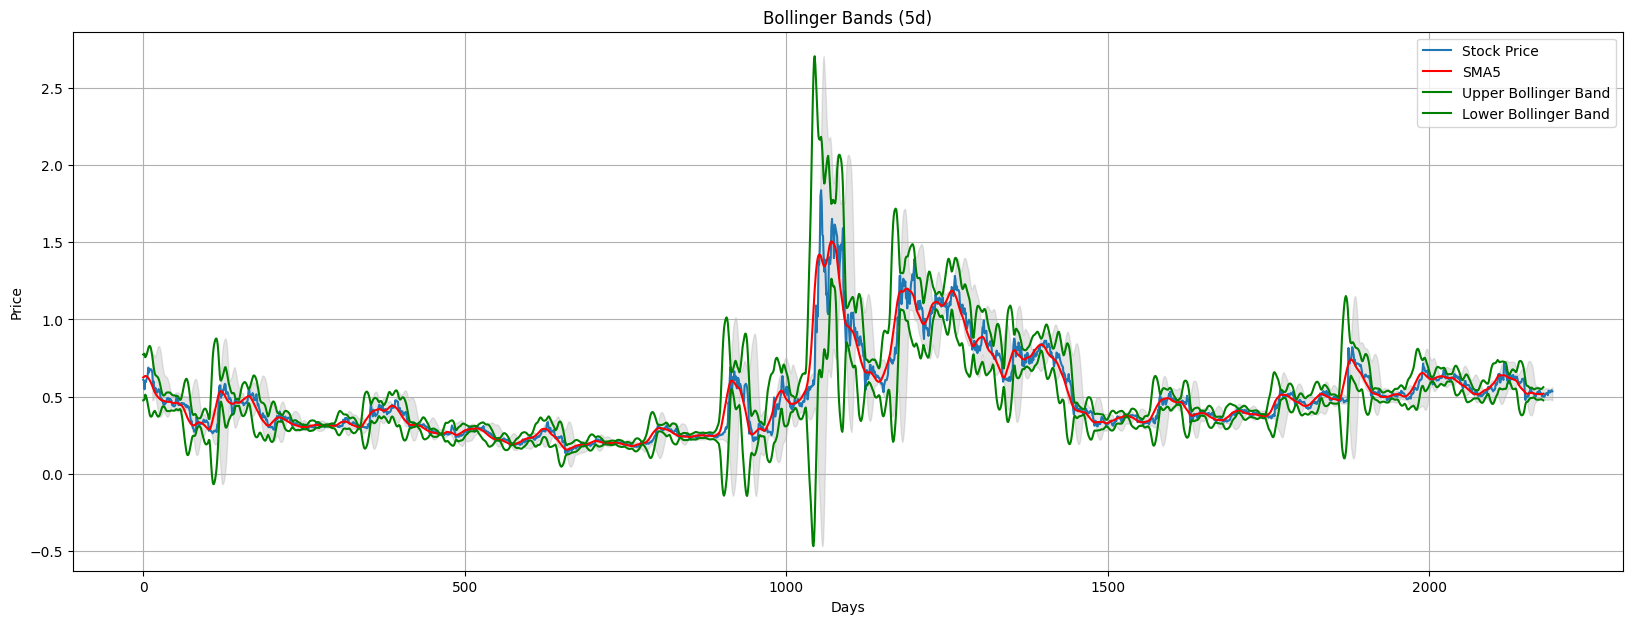

In [22]:
# Plotting 5d
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Stock Price')
plt.plot(rolling_mean_5, label='SMA5', color='red')
plt.plot(upper_band_5, label='Upper Bollinger Band', color='green')
plt.plot(lower_band_5, label='Lower Bollinger Band', color='green')
plt.fill_between(np.arange(window_size-1, len(df['5d_sma'])), lower_band_5, upper_band_5, color='grey', alpha=0.2)
plt.title('Bollinger Bands (5d)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

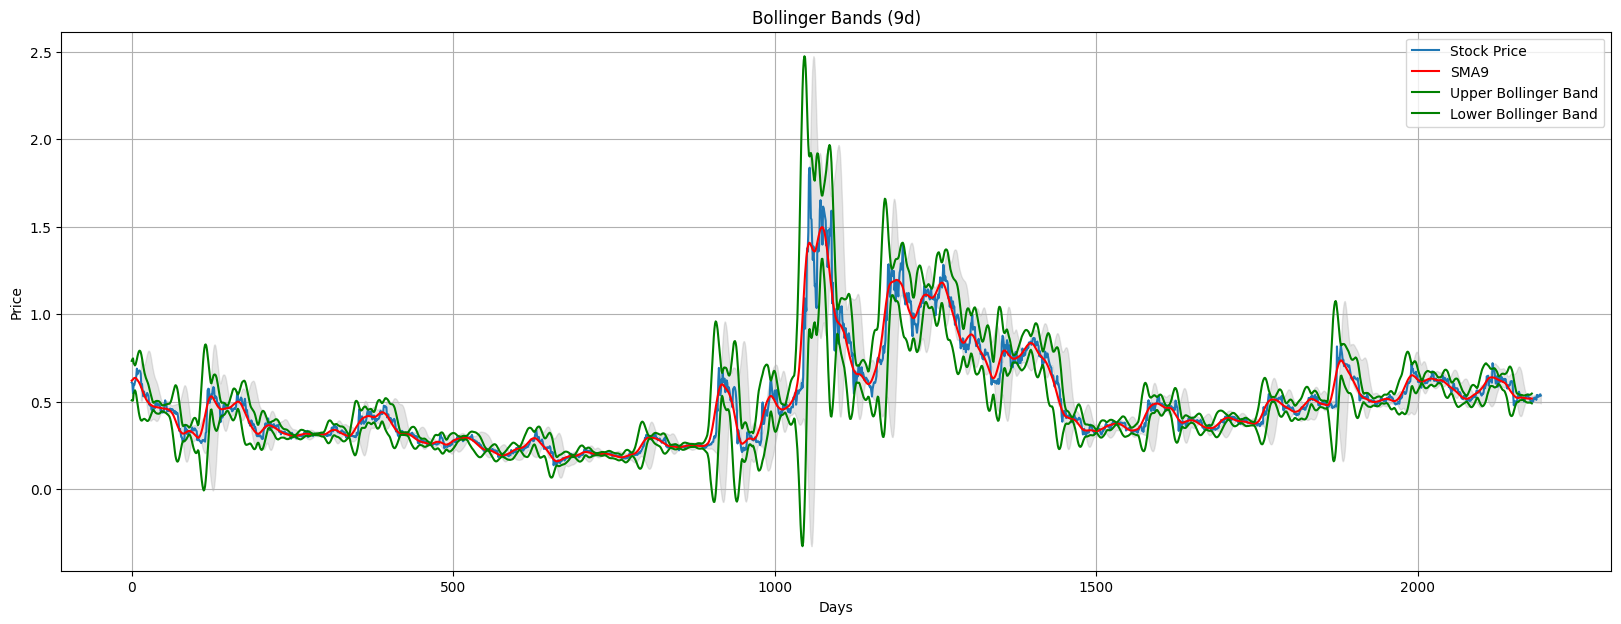

In [23]:
# Plotting 9d
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Stock Price')
plt.plot(rolling_mean_9, label='SMA9', color='red')
plt.plot(upper_band_9, label='Upper Bollinger Band', color='green')
plt.plot(lower_band_9, label='Lower Bollinger Band', color='green')
plt.fill_between(np.arange(window_size-1, len(df['9d_sma'])), lower_band_9, upper_band_9,
                 color='grey', alpha=0.2)
plt.title('Bollinger Bands (9d)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

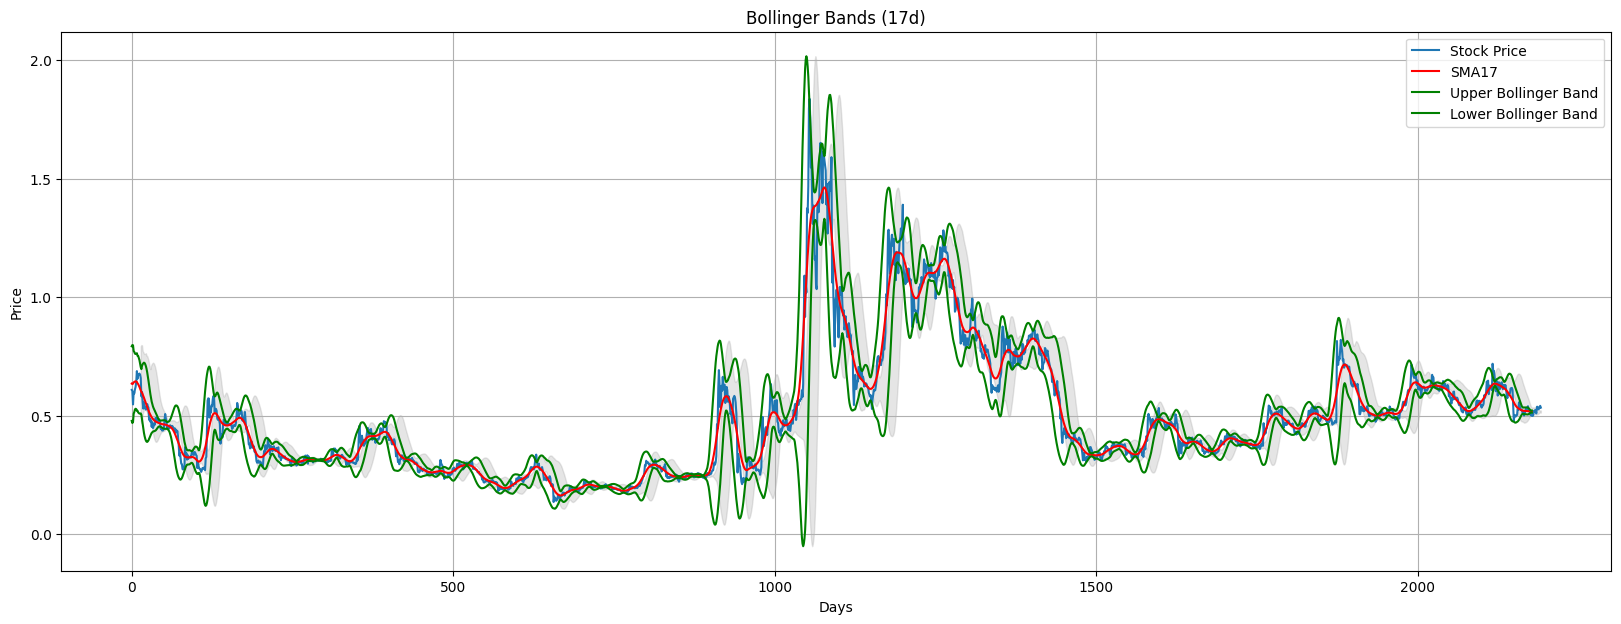

In [24]:
# Plotting
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Stock Price')
plt.plot(rolling_mean_17, label='SMA17', color='red')
plt.plot(upper_band_17, label='Upper Bollinger Band', color='green')
plt.plot(lower_band_17, label='Lower Bollinger Band', color='green')
plt.fill_between(np.arange(window_size-1, len(df['17d_sma'])), lower_band_17, upper_band_17,
                 color='grey', alpha=0.2)
plt.title('Bollinger Bands (17d)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
df['Days'] = df.index + 1

In [26]:
_5d = df[['Open','High','Low','Days', '5d_sma','Volume','Close']].copy(deep=True)
_9d = df[['Open','High','Low','Days', '9d_sma','Volume','Close']].copy(deep=True)
_17d = df[['Open','High','Low','Days', '17d_sma','Volume','Close']].copy(deep=True)
_all = df[['Open','High','Low','Days', '5d_sma', '9d_sma', '17d_sma','Volume','Close']].copy(deep=True)

In [27]:
scaler = MinMaxScaler(feature_range=(0,2)).fit(_5d.Low.values.reshape(-1,1))
_5d['Open'] = scaler.transform(_5d.Open.values.reshape(-1,1))
_5d['High'] = scaler.transform(_5d.High.values.reshape(-1,1))
_5d['Low'] = scaler.transform(_5d.Low.values.reshape(-1,1))
_5d['Close'] = scaler.transform(_5d.Close.values.reshape(-1,1))
_5d['Volume'] = scaler.transform(_5d.Volume.values.reshape(-1,1))
_5d['Days'] = scaler.transform(_5d.Days.values.reshape(-1,1))
_5d['5d_sma'] = scaler.transform(_5d['5d_sma'].values.reshape(-1,1))

scaler = MinMaxScaler(feature_range=(0,2)).fit(_9d.Low.values.reshape(-1,1))
_9d['Open'] = scaler.transform(_9d.Open.values.reshape(-1,1))
_9d['High'] = scaler.transform(_9d.High.values.reshape(-1,1))
_9d['Low'] = scaler.transform(_9d.Low.values.reshape(-1,1))
_9d['Close'] = scaler.transform(_9d.Close.values.reshape(-1,1))
_9d['Volume'] = scaler.transform(_9d.Volume.values.reshape(-1,1))
_9d['Days'] = scaler.transform(_9d.Days.values.reshape(-1,1))
_9d['9d_sma'] = scaler.transform(_9d['9d_sma'].values.reshape(-1,1))

scaler = MinMaxScaler(feature_range=(0,2)).fit(_17d.Low.values.reshape(-1,1))
_17d['Open'] = scaler.transform(_17d.Open.values.reshape(-1,1))
_17d['High'] = scaler.transform(_17d.High.values.reshape(-1,1))
_17d['Low'] = scaler.transform(_17d.Low.values.reshape(-1,1))
_17d['Close'] = scaler.transform(_17d.Close.values.reshape(-1,1))
_17d['Volume'] = scaler.transform(_17d.Volume.values.reshape(-1,1))
_17d['Days'] = scaler.transform(_17d.Days.values.reshape(-1,1))
_17d['17d_sma'] = scaler.transform(_17d['17d_sma'].values.reshape(-1,1))

scaler = MinMaxScaler(feature_range=(0,2)).fit(_all.Low.values.reshape(-1,1))
_all['Open'] = scaler.transform(_all.Open.values.reshape(-1,1))
_all['High'] = scaler.transform(_all.High.values.reshape(-1,1))
_all['Low'] = scaler.transform(_all.Low.values.reshape(-1,1))
_all['Close'] = scaler.transform(_all.Close.values.reshape(-1,1))
_all['Volume'] = scaler.transform(_all.Volume.values.reshape(-1,1))
_all['Days'] = scaler.transform(_all.Days.values.reshape(-1,1))
_all['5d_sma'] = scaler.transform(_all['5d_sma'].values.reshape(-1,1))
_all['9d_sma'] = scaler.transform(_all['9d_sma'].values.reshape(-1,1))
_all['17d_sma'] = scaler.transform(_all['17d_sma'].values.reshape(-1,1))


data_5d_all = _5d[['Open','High','Low','Close', '5d_sma', 'Volume', 'Days']].values
data_5d = _5d[['Open','High','Low','Close', '5d_sma']].values
data_9d = _9d[['Open','High','Low', '9d_sma','Close']].values
data_17d = _17d[['Open','High','Low', '17d_sma','Close']].values
data_all = _all[['Open','High','Low', '5d_sma', '9d_sma', '17d_sma','Close']].values

In [28]:
joblib.dump(scaler, 'scaler_all.pkl') # لحفظ scaler الخاص بـ _all


['scaler_all.pkl']

In [29]:
print(data_5d_all.shape)
print(data_5d.shape)
print(data_9d.shape)
print(data_17d.shape)
print(data_all.shape)

(2192, 7)
(2192, 5)
(2192, 5)
(2192, 5)
(2192, 7)


In [30]:
seq_len= 11
sequences_5d_all=[]
for index in range(len(data_5d_all) - seq_len + 1):
    sequences_5d_all.append(data_5d_all[index: index + seq_len])
sequences_5d_all = np.array(sequences_5d_all)
print(sequences_5d_all.shape)


seq_len= 11
sequences_5d=[]
for index in range(len(data_5d) - seq_len + 1):
    sequences_5d.append(data_5d[index: index + seq_len])
sequences_5d = np.array(sequences_5d)
print(sequences_5d.shape)


sequences_9d=[]
for index in range(len(data_9d) - seq_len + 1):
    sequences_9d.append(data_9d[index: index + seq_len])
sequences_9d = np.array(sequences_9d)
print(sequences_9d.shape)


sequences_17d=[]
for index in range(len(data_17d) - seq_len + 1):
    sequences_17d.append(data_17d[index: index + seq_len])
sequences_17d = np.array(sequences_17d)
print(sequences_17d.shape)


sequences_all=[]
for index in range(len(data_all) - seq_len + 1):
    sequences_all.append(data_all[index: index + seq_len])
sequences_all = np.array(sequences_all)
print(sequences_all.shape)

(2182, 11, 7)
(2182, 11, 5)
(2182, 11, 5)
(2182, 11, 5)
(2182, 11, 7)


In [31]:
valid_set_size_percentage = 10
test_set_size_percentage = 10


valid_set_size_5d_all = int(np.round(valid_set_size_percentage/100*sequences_5d_all.shape[0]))
test_set_size_5d_all  = int(np.round(test_set_size_percentage/100*sequences_5d_all.shape[0]))
train_set_size_5d_all = sequences_5d_all.shape[0] - (valid_set_size_5d_all + test_set_size_5d_all)

x_train_5d_all = sequences_5d_all[:train_set_size_5d_all,:-1,:]
y_train_5d_all = sequences_5d_all[:train_set_size_5d_all,-1,:]

x_valid_5d_all = sequences_5d_all[train_set_size_5d_all:train_set_size_5d_all+valid_set_size_5d_all,
                                  :-1,:]
y_valid_5d_all = sequences_5d_all[train_set_size_5d_all:train_set_size_5d_all+valid_set_size_5d_all
                                  ,-1,:]

x_test_5d_all = sequences_5d_all[train_set_size_5d_all+valid_set_size_5d_all:,:-1,:]
y_test_5d_all = sequences_5d_all[train_set_size_5d_all+valid_set_size_5d_all:,-1,:]




valid_set_size_5d = int(np.round(valid_set_size_percentage/100*sequences_5d.shape[0]))
test_set_size_5d  = int(np.round(test_set_size_percentage/100*sequences_5d.shape[0]))
train_set_size_5d = sequences_5d.shape[0] - (valid_set_size_5d + test_set_size_5d)

x_train_5d = sequences_5d[:train_set_size_5d,:-1,:]
y_train_5d = sequences_5d[:train_set_size_5d,-1,:]

x_valid_5d = sequences_5d[train_set_size_5d:train_set_size_5d+valid_set_size_5d,:-1,:]
y_valid_5d = sequences_5d[train_set_size_5d:train_set_size_5d+valid_set_size_5d,-1,:]

x_test_5d = sequences_5d[train_set_size_5d+valid_set_size_5d:,:-1,:]
y_test_5d = sequences_5d[train_set_size_5d+valid_set_size_5d:,-1,:]



valid_set_size_9d = int(np.round(valid_set_size_percentage/100*sequences_9d.shape[0]))
test_set_size_9d  = int(np.round(test_set_size_percentage/100*sequences_9d.shape[0]))
train_set_size_9d = sequences_9d.shape[0] - (valid_set_size_9d + test_set_size_9d)

x_train_9d = sequences_9d[:train_set_size_9d,:-1,:]
y_train_9d = sequences_9d[:train_set_size_9d,-1,:]

x_valid_9d = sequences_9d[train_set_size_9d:train_set_size_9d+valid_set_size_9d,:-1,:]
y_valid_9d = sequences_9d[train_set_size_9d:train_set_size_9d+valid_set_size_9d,-1,:]

x_test_9d = sequences_9d[train_set_size_9d+valid_set_size_9d:,:-1,:]
y_test_9d = sequences_9d[train_set_size_9d+valid_set_size_9d:,-1,:]



valid_set_size_17d = int(np.round(valid_set_size_percentage/100*sequences_17d.shape[0]))
test_set_size_17d  = int(np.round(test_set_size_percentage/100*sequences_17d.shape[0]))
train_set_size_17d = sequences_17d.shape[0] - (valid_set_size_17d + test_set_size_17d)

x_train_17d = sequences_17d[:train_set_size_17d,:-1,:]
y_train_17d = sequences_17d[:train_set_size_17d,-1,:]

x_valid_17d = sequences_17d[train_set_size_17d:train_set_size_17d+valid_set_size_17d,:-1,:]
y_valid_17d = sequences_17d[train_set_size_17d:train_set_size_17d+valid_set_size_17d,-1,:]
x_test_17d = sequences_17d[train_set_size_17d+valid_set_size_17d:,:-1,:]
y_test_17d = sequences_17d[train_set_size_17d+valid_set_size_17d:,-1,:]



valid_set_size_all = int(np.round(valid_set_size_percentage/100*sequences_all.shape[0]))
test_set_size_all  = int(np.round(test_set_size_percentage/100*sequences_all.shape[0]))
train_set_size_all = sequences_5d.shape[0] - (valid_set_size_all + test_set_size_all)

x_train_all = sequences_all[:train_set_size_all,:-1,:]
y_train_all = sequences_all[:train_set_size_all,-1,:]

x_valid_all = sequences_all[train_set_size_all:train_set_size_all+valid_set_size_all,:-1,:]
y_valid_all = sequences_all[train_set_size_all:train_set_size_all+valid_set_size_all,-1,:]

x_test_all = sequences_all[train_set_size_all+valid_set_size_all:,:-1,:]
y_test_all = sequences_all[train_set_size_all+valid_set_size_all:,-1,:]

In [32]:
x_train_5d_all = torch.tensor(x_train_5d_all).float()
y_train_5d_all = torch.tensor(y_train_5d_all).float()

x_valid_5d_all = torch.tensor(x_valid_5d_all).float()
y_valid_5d_all = torch.tensor(y_valid_5d_all).float()

train_dataset_5d_all = TensorDataset(x_train_5d_all,y_train_5d_all)
train_dataloader_5d_all = DataLoader(train_dataset_5d_all, batch_size=32, shuffle=False)

valid_dataset_5d_all = TensorDataset(x_valid_5d_all,y_valid_5d_all)
valid_dataloader_5d_all = DataLoader(valid_dataset_5d_all, batch_size=32, shuffle=False)




x_train_5d = torch.tensor(x_train_5d).float()
y_train_5d = torch.tensor(y_train_5d).float()

x_valid_5d = torch.tensor(x_valid_5d).float()
y_valid_5d = torch.tensor(y_valid_5d).float()

train_dataset_5d = TensorDataset(x_train_5d,y_train_5d)
train_dataloader_5d = DataLoader(train_dataset_5d, batch_size=32, shuffle=False)

valid_dataset_5d = TensorDataset(x_valid_5d,y_valid_5d)
valid_dataloader_5d = DataLoader(valid_dataset_5d, batch_size=32, shuffle=False)



x_train_9d = torch.tensor(x_train_9d).float()
y_train_9d = torch.tensor(y_train_9d).float()

x_valid_9d = torch.tensor(x_valid_9d).float()
y_valid_9d = torch.tensor(y_valid_9d).float()

train_dataset_9d = TensorDataset(x_train_9d,y_train_9d)
train_dataloader_9d = DataLoader(train_dataset_9d, batch_size=32, shuffle=False)

valid_dataset_9d = TensorDataset(x_valid_9d,y_valid_9d)
valid_dataloader_9d = DataLoader(valid_dataset_9d, batch_size=32, shuffle=False)



x_train_17d = torch.tensor(x_train_17d).float()
y_train_17d = torch.tensor(y_train_17d).float()

x_valid_17d = torch.tensor(x_valid_17d).float()
y_valid_17d = torch.tensor(y_valid_17d).float()

train_dataset_17d = TensorDataset(x_train_17d,y_train_17d)
train_dataloader_17d = DataLoader(train_dataset_17d, batch_size=32, shuffle=False)

valid_dataset_17d = TensorDataset(x_valid_17d,y_valid_17d)
valid_dataloader_17d = DataLoader(valid_dataset_17d, batch_size=32, shuffle=False)



x_train_all = torch.tensor(x_train_all).float()
y_train_all = torch.tensor(y_train_all).float()

x_valid_all = torch.tensor(x_valid_all).float()
y_valid_all = torch.tensor(y_valid_all).float()

train_dataset_all = TensorDataset(x_train_all,y_train_all)
train_dataloader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=False)

valid_dataset_all = TensorDataset(x_valid_all,y_valid_all)
valid_dataloader_all = DataLoader(valid_dataset_all, batch_size=32, shuffle=False)

In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)


    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

In [34]:
model_5d_all = NeuralNetwork(7)

In [35]:
optimizer = optim.Adam(model_5d_all.parameters())
mse = nn.MSELoss()

In [36]:
def train(dataloader):
    epoch_loss = 0
    model_5d_all.train()

    for batch in dataloader:
        optimizer.zero_grad()
        x,y= batch
        pred = model_5d_all(x)
        loss = mse(pred[0],y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss

In [37]:
def evaluate(dataloader):
    epoch_loss = 0
    model_5d_all.eval()

    with torch.no_grad():
        for batch in dataloader:
            x,y= batch
            pred = model_5d_all(x)
            loss = mse(pred[0],y)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [38]:
n_epochs = 100
best_valid_loss_5d_all = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss_5d_all = train(train_dataloader_5d_all)
    valid_loss_5d_all = evaluate(valid_dataloader_5d_all)

    #save the best model
    if valid_loss_5d_all < best_valid_loss_5d_all:
        best_valid_loss_5d_all = valid_loss_5d_all
        torch.save(model_5d_all, 'saved_weights_5d_all.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss_5d_all:.5f} | ' + f'\tVal Loss: {valid_loss_5d_all:.5f}\n')

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 3120662152402417221632.00000 | 	Val Loss: 4441369353524646400.00000

	Train Loss: 312

In [39]:
model_5d_all = torch.load('saved_weights_5d_all.pt', weights_only=False)


In [40]:
x_test_5d_all = torch.tensor(x_test_5d_all).float()

with torch.no_grad():
    y_test_pred_5d_all = model_5d_all(x_test_5d_all)

y_test_pred_5d_all = y_test_pred_5d_all.numpy()[0]

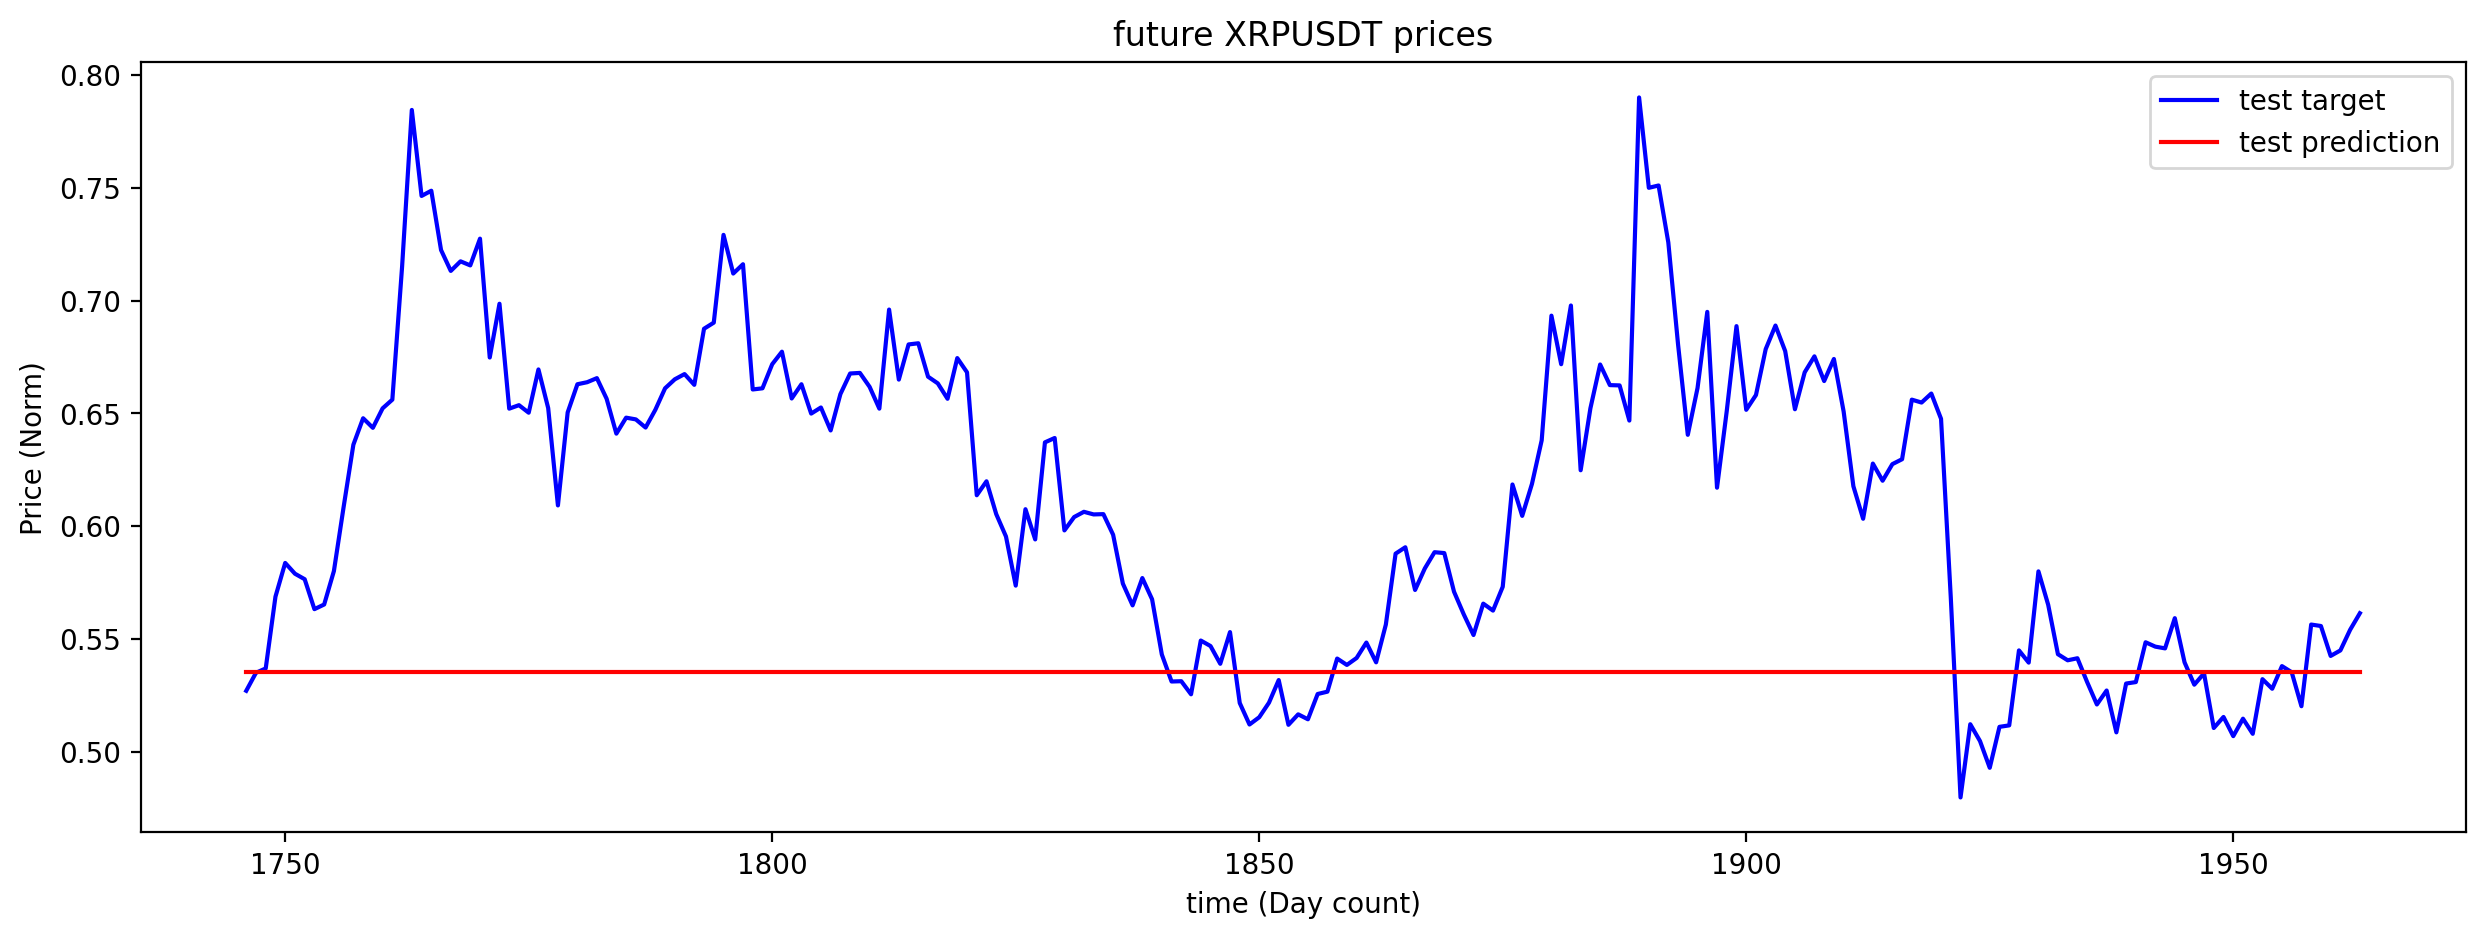

In [43]:
idx=0
plt.figure(figsize=(15,5), dpi=200)
plt.plot(np.arange(y_train_5d_all.shape[0], y_train_5d_all.shape[0]+y_test_5d_all.shape[0]),
         y_test_5d_all[:,idx], color='blue', label='test target')

plt.plot(np.arange(y_train_5d_all.shape[0], y_train_5d_all.shape[0]+y_test_pred_5d_all.shape[0]),
         y_test_pred_5d_all[:,idx], color='red', label='test prediction')

plt.title('future XRPUSDT prices')
plt.xlabel('time (Day count)')
plt.ylabel('Price (Norm)')
plt.legend(loc='best')
plt.plot();

In [44]:
model_5d = NeuralNetwork(5)

In [45]:
optimizer = optim.Adam(model_5d.parameters())

In [46]:
def train(dataloader):
    epoch_loss = 0
    model_5d.train()

    for batch in dataloader:
        optimizer.zero_grad()
        x,y= batch
        pred = model_5d(x)
        loss = mse(pred[0],y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss

In [47]:
def evaluate(dataloader):
    epoch_loss = 0
    model_5d.eval()

    with torch.no_grad():
        for batch in dataloader:
            x,y= batch
            pred = model_5d(x)
            loss = mse(pred[0],y)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [48]:
n_epochs = 100
best_valid_loss_5d = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss_5d = train(train_dataloader_5d)
    valid_loss_5d = evaluate(valid_dataloader_5d)

    #save the best model
    if valid_loss_5d < best_valid_loss_5d:
        best_valid_loss_5d = valid_loss_5d
        torch.save(model_5d, 'saved_weights_5d.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss_5d:.5f} | ' + f'\tVal Loss: {valid_loss_5d:.5f}\n')

	Train Loss: 5.66798 | 	Val Loss: 0.00383

	Train Loss: 3.34862 | 	Val Loss: 0.01727

	Train Loss: 1.34593 | 	Val Loss: 0.00352

	Train Loss: 0.47712 | 	Val Loss: 0.00564

	Train Loss: 0.41890 | 	Val Loss: 0.00585

	Train Loss: 0.40513 | 	Val Loss: 0.00575

	Train Loss: 0.39554 | 	Val Loss: 0.00574

	Train Loss: 0.38666 | 	Val Loss: 0.00567

	Train Loss: 0.37905 | 	Val Loss: 0.00563

	Train Loss: 0.37250 | 	Val Loss: 0.00555

	Train Loss: 0.36408 | 	Val Loss: 0.00533

	Train Loss: 0.34985 | 	Val Loss: 0.00494

	Train Loss: 0.32994 | 	Val Loss: 0.00449

	Train Loss: 0.30846 | 	Val Loss: 0.00408

	Train Loss: 0.28862 | 	Val Loss: 0.00374

	Train Loss: 0.27141 | 	Val Loss: 0.00346

	Train Loss: 0.25649 | 	Val Loss: 0.00323

	Train Loss: 0.24287 | 	Val Loss: 0.00301

	Train Loss: 0.22963 | 	Val Loss: 0.00281

	Train Loss: 0.21634 | 	Val Loss: 0.00260

	Train Loss: 0.20316 | 	Val Loss: 0.00241

	Train Loss: 0.19063 | 	Val Loss: 0.00224

	Train Loss: 0.17924 | 	Val Loss: 0.00209

	Train Loss

In [49]:
model_5d =torch.load('saved_weights_5d.pt', weights_only=False)

In [50]:
x_test_5d = torch.tensor(x_test_5d).float()

with torch.no_grad():
    y_test_pred_5d = model_5d(x_test_5d)

y_test_pred_5d = y_test_pred_5d.numpy()[0]

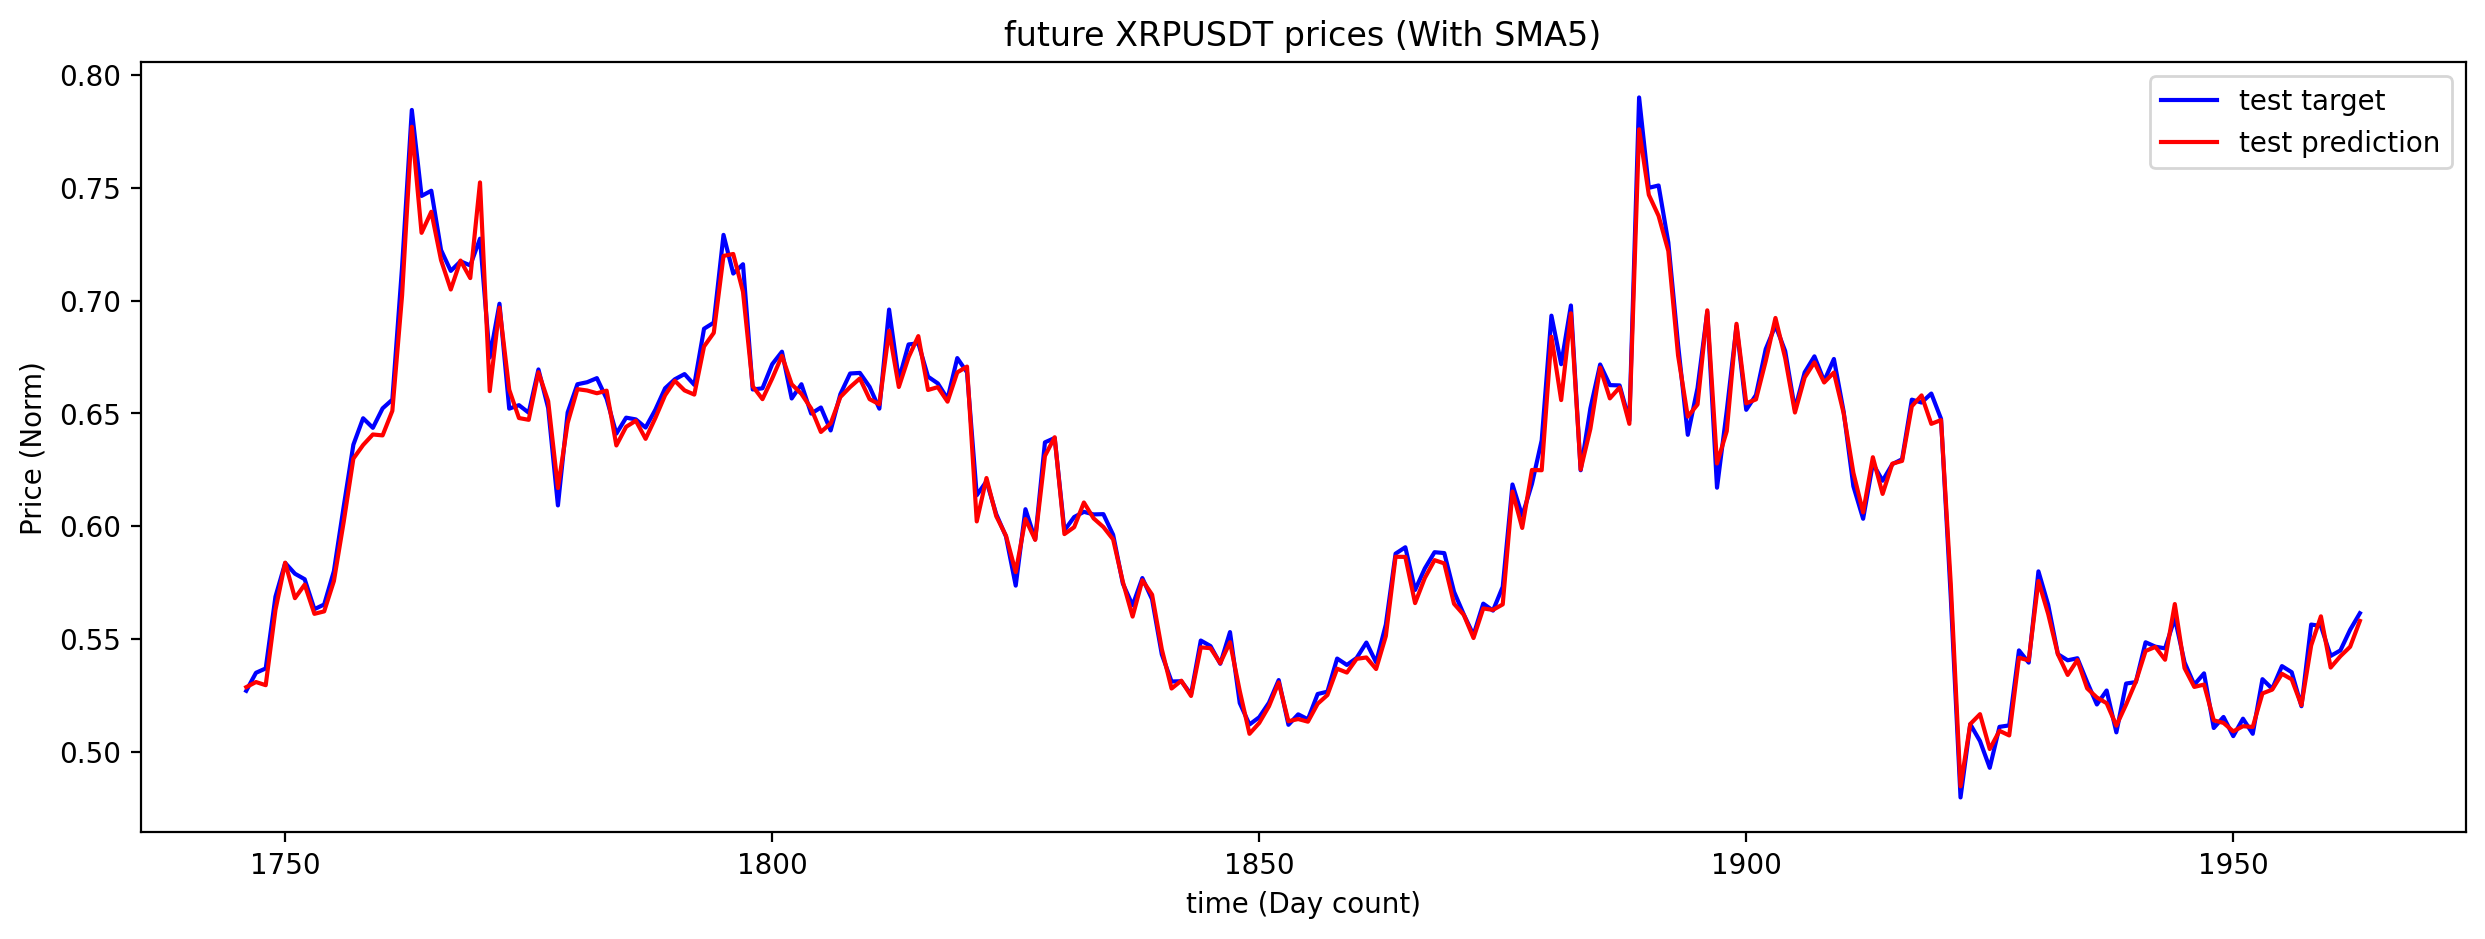

In [51]:
idx=0
plt.figure(figsize=(15,5), dpi=200)
plt.plot(np.arange(y_train_5d.shape[0], y_train_5d.shape[0]+y_test_5d.shape[0]),
         y_test_5d[:,idx], color='blue', label='test target')

plt.plot(np.arange(y_train_5d.shape[0], y_train_5d.shape[0]+y_test_pred_5d.shape[0]),
         y_test_pred_5d[:,idx], color='red', label='test prediction')

plt.title('future XRPUSDT prices (With SMA5)')
plt.xlabel('time (Day count)')
plt.ylabel('Price (Norm)')
plt.legend(loc='best')
plt.plot();

In [52]:
model_all = NeuralNetwork(7)

In [53]:
optimizer = optim.Adam(model_all.parameters())

In [54]:
def train(dataloader):
    epoch_loss = 0
    model_all.train()

    for batch in dataloader:
        optimizer.zero_grad()
        x,y= batch
        pred = model_all(x)
        loss = mse(pred[0],y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss

In [55]:
def evaluate(dataloader):
    epoch_loss = 0
    model_all.eval()

    with torch.no_grad():
        for batch in dataloader:
            x,y= batch
            pred = model_all(x)
            loss = mse(pred[0],y)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [57]:
n_epochs = 150
best_valid_loss_all = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss_all = train(train_dataloader_all)
    valid_loss_all = evaluate(valid_dataloader_all)

    #save the best model
    if valid_loss_all < best_valid_loss_all:
        best_valid_loss_all = valid_loss_all
        torch.save(model_all, 'saved_weights_all.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss_all:.5f} | ' + f'\tVal Loss: {valid_loss_all:.5f}\n')

	Train Loss: 0.10744 | 	Val Loss: 0.00239

	Train Loss: 0.10234 | 	Val Loss: 0.00343

	Train Loss: 0.13950 | 	Val Loss: 0.00278

	Train Loss: 0.10174 | 	Val Loss: 0.00243

	Train Loss: 0.14401 | 	Val Loss: 0.00177

	Train Loss: 0.07224 | 	Val Loss: 0.00087

	Train Loss: 0.06621 | 	Val Loss: 0.00072

	Train Loss: 0.06746 | 	Val Loss: 0.00086

	Train Loss: 0.06449 | 	Val Loss: 0.00083

	Train Loss: 0.05323 | 	Val Loss: 0.00066

	Train Loss: 0.05152 | 	Val Loss: 0.00065

	Train Loss: 0.05341 | 	Val Loss: 0.00076

	Train Loss: 0.05360 | 	Val Loss: 0.00084

	Train Loss: 0.05371 | 	Val Loss: 0.00081

	Train Loss: 0.05605 | 	Val Loss: 0.00075

	Train Loss: 0.05996 | 	Val Loss: 0.00079

	Train Loss: 0.05934 | 	Val Loss: 0.00079

	Train Loss: 0.05207 | 	Val Loss: 0.00068

	Train Loss: 0.04864 | 	Val Loss: 0.00062

	Train Loss: 0.05016 | 	Val Loss: 0.00065

	Train Loss: 0.05243 | 	Val Loss: 0.00083

	Train Loss: 0.05275 | 	Val Loss: 0.00100

	Train Loss: 0.05226 | 	Val Loss: 0.00097

	Train Loss

In [58]:
model_all =torch.load('saved_weights_all.pt', weights_only=False)

In [59]:
x_test_all = torch.tensor(x_test_all).float()

with torch.no_grad():
    y_test_pred_all = model_all(x_test_all)

y_test_pred_all = y_test_pred_all.numpy()[0]

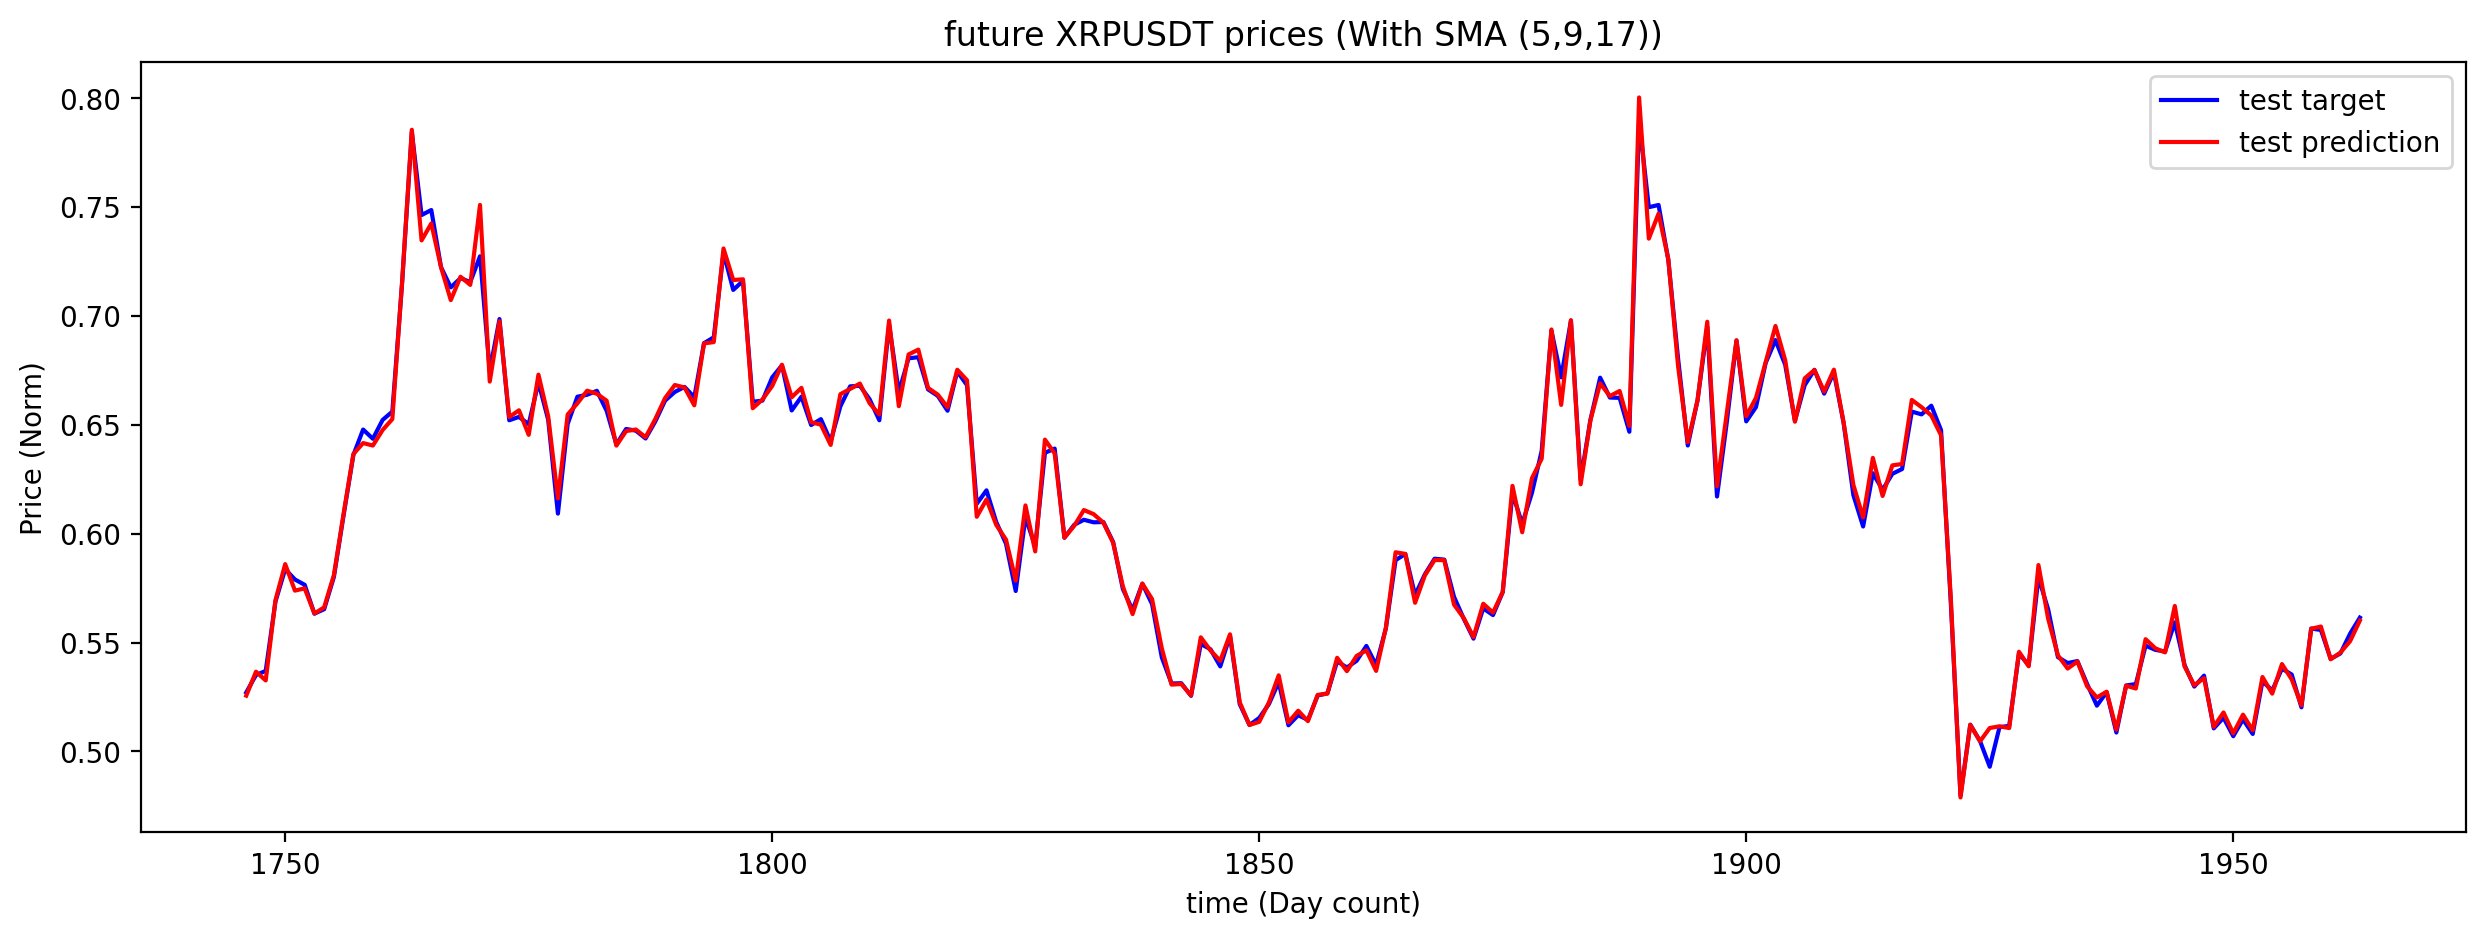

In [60]:
idx=0
plt.figure(figsize=(15,5), dpi=200)
plt.plot(np.arange(y_train_all.shape[0], y_train_all.shape[0]+y_test_all.shape[0]),
         y_test_all[:,idx], color='blue', label='test target')

plt.plot(np.arange(y_train_all.shape[0], y_train_all.shape[0]+y_test_pred_all.shape[0]),
         y_test_pred_all[:,idx], color='red', label='test prediction')

plt.title('future XRPUSDT prices (With SMA (5,9,17))')
plt.xlabel('time (Day count)')
plt.ylabel('Price (Norm)')
plt.legend(loc='best')
plt.plot();